In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import networkx as nx
import random

In [5]:
def multinomial_argmax(probabilities):
    # normalize probabilities to sum to 1
    probabilities = np.asarray(probabilities)
    probabilities /= probabilities.sum()

    # draw a sample from the multinomial distribution
    sample = np.random.multinomial(1, probabilities)

    # get the index of the selected element
    index = np.argmax(sample)

    return index

def normalize_list(l):
    return [i/sum(l) for i in l]

def roulette_wheel_selection(population, costs, parent_size):
    max_cost = 1
    fitnesses = [max_cost +1 -cost for cost in costs]
    probabilities = normalize_list(fitnesses)

    # checked that sum(probabilities) = 1
    if sum(probabilities) < 0.999:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must sum to 1.')
    elif sum(probabilities) > 1.001:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must not over 1.')
        
    selected = []
    
    print('start selecting parents')
    while len(selected) < parent_size:
        print(f'population: {population}')

        print(f'probabilities: {probabilities}, and sum is: {sum(probabilities)}')
        index = multinomial_argmax(probabilities)
        print(f'index: {index}')
        chosen_parent = population[index]
        print(f'chosen parent: {chosen_parent}')

        selected.append(chosen_parent)

        del population[index]
        del probabilities[index]
        print(f'population: {population}')
        
    return selected

def cost_to_fitness(cost_list):
    # transform the cost to a fitness value
    fitness_list = [1 / (1 + cost) for cost in cost_list]
    print(f'fitness_list: {fitness_list}')
    print(f'sum of fitness_list: {sum(fitness_list)}')
    min_fitness = min(fitness_list)
    max_fitness = max(fitness_list)
    print(f'min_fitness: {min_fitness}, max_fitness: {max_fitness}')
    
    # normalize the fitness value to [0, 1]
    normalized_fitness = [fitness/sum(fitness_list) for fitness in fitness_list]
    
    return normalized_fitness

def normalize_fitness(fitness_values):
    # Calculate the sum of fitness values
    fitness_sum = sum(fitness_values)
    
    # Divide each fitness value by the sum to normalize
    normalized_fitness = [fitness / fitness_sum for fitness in fitness_values]
    
    return normalized_fitness


# Cost
interval [0,1], 1 => best, 0 => worst

\begin{equation}
    cost = \frac{1}{log_{x_{b}}x_{i}}
\end{equation}

\begin{equation}
    C(x_{1},...,x_{N}) = \sum_{i=1}^N \frac{1}{log_{x_{b}}x_{i}}
\end{equation}

/var/folders/b7/kcj1zfy15d35hgd16vscfs0r0000gn/T/ipykernel_40539/991286755.py:2: RuntimeWarning: divide by zero encountered in log
  y = 1/(np.log(x)/np.log(base))
/var/folders/b7/kcj1zfy15d35hgd16vscfs0r0000gn/T/ipykernel_40539/991286755.py:2: RuntimeWarning: divide by zero encountered in divide
  y = 1/(np.log(x)/np.log(base))


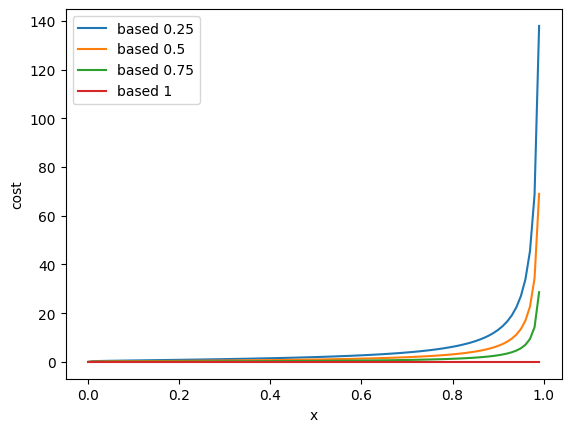

In [56]:
def cost_plot(x, base):
    y = 1/(np.log(x)/np.log(base))
    return y

plt.xlabel('x') # a set of parameter that mapped to a cost
plt.ylabel('cost')

for base in [0.25, 0.5, 0.75, 1]:
    plt.plot(np.arange(0, 1, 0.01), cost_plot(np.arange(0, 1, 0.01), base), label=f'based {base}')
    # plt.plot([base, base], [0,100], '--')

plt.legend()

In [42]:
print(cost_plot(x=0.3, base=0.5))
print(cost_plot(x=0.5, base=0.5))
print(cost_plot(x=0.7, base=0.5))

0.5757166424934449
1.0
1.9433582098747315


In [46]:
def first(x_b, k):
    x_new = x_b**(1/k)
    return x_new

/var/folders/b7/kcj1zfy15d35hgd16vscfs0r0000gn/T/ipykernel_40539/2839968449.py:2: RuntimeWarning: divide by zero encountered in divide
  x_new = x_b**(1/k)


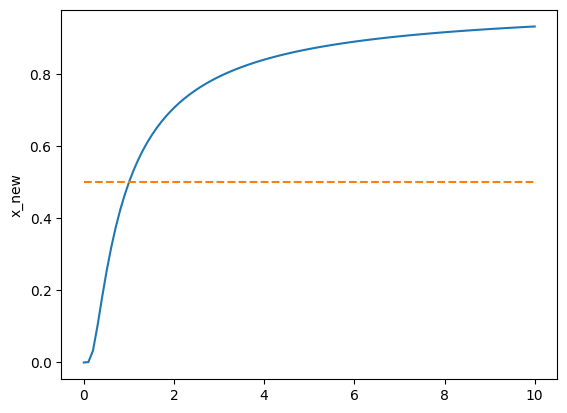

In [55]:
x = np.linspace(0, 10, 100)
x_b = 0.5
y = first(x_b=x_b, k=x)
plt.ylabel('x_new')
plt.plot(x, y)
plt.plot([0,10], [x_b, x_b], '--')


In [115]:
def create_population(population_size, num_parameter=4):
    # create individual in population
    population = []
    for i in range(population_size):
        individual = [random.random() for i in range(num_parameter)]
        population.append(individual)
    
    return population

def crossover(parents, cross, population_size):
    offspring = []
    numParent = len(parents)

    num_cross = int(cross*population_size)
    num_pick = population_size - num_cross
    print(f'num_cross: {num_cross}, num_pick: {num_pick}')

    # crossover
    for i in range(num_cross):
        
        #select two parents
        pool = parents
        parent1 = random.choice(pool)
        parent2 = random.choice(pool)

        #select random point to crossover
        crossover_point = random.randint(0, len(parent1)-1)
            
        #create child
        child = parent1[:crossover_point] + parent2[crossover_point:]
        offspring.append(child)
    print(f'offspring after cross: {len(offspring)}')

    # pick
    for i in range(num_pick):
        picked_ind = random.choice(parents)
        offspring.append(picked_ind)
        # del parents[parents.index(picked_ind)]
    print(f'offspring after pick: {len(offspring)}')

    if num_cross+num_pick != population_size:
        print(f'Num cross: {num_cross}, Num pick: {num_pick}, Num parents: {numParent}')
        raise ValueError('Number is not match in crossover function parent')
    
    elif num_cross+num_pick != len(offspring):
        print(f'Num cross: {num_cross}, Num pick: {num_pick}, Num offspring: {len(offspring)}')
        raise ValueError('Number is not match in crossover function offspring')

    return offspring

def roulette_wheel_selection(population, costs, parent_size):
    """
        Performs roulette wheel selection on a population based on their fitnesses.
        Args:
            population (list): List of individuals.
            fitnesses (list): List of corresponding fitness values for the individuals.
            num_selected (int): Number of individuals to select.
        Returns:
            selected (list): List of selected individuals.
    """

    # prevent changing original population
    dum_population = population[:]
    print(len(dum_population), len(population))

    fitness_list = [1 / (1 + cost) for cost in costs]
    # print(fitness_list)

    probabilities = [fitness/np.sum(fitness_list) for fitness in fitness_list]
    # print(f'probabilities: {probabilities}, and sum is: {sum(probabilities)}')

    # checked that sum(probabilities) = 1
    if np.sum(probabilities) < 0.999:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must sum to 1.')
    elif np.sum(probabilities) > 1.001:
        print(f'Sum Probability: {sum(probabilities)}')
        raise ValueError('Probabilities must not over 1.')
        
    selected = []
    
    # print('start selecting parents')
    while len(selected) < parent_size:
    
        index = multinomial_argmax(probabilities)        
        chosen_parent = dum_population[index]

        selected.append(chosen_parent)

        dum_population.pop(index)
        probabilities.pop(index)
        print(f'num dum_population: {len(dum_population)}') # expect to decrease
        print(f'num population: {len(population)}') # expect to not decrease
        
    return selected

In [116]:
population = create_population(population_size=50, num_parameter=4)
cost_value = [1.945074460237905, 5.723117049688897, 10.19354411792085, 1.6850255137675068, 4.4254081547309, 4.0390398813191855, 6.0857742323886965, 3.4817075737754983, 5.111420184626466, 4.937073478920119, 1.9374992464219414, 4.056022181421867, 1.9984203050574167, 3.241191633714245, 3.5806621292044634, 9.400384324509663, 4.641927152719156, 3.3826357642729756, 2.6447892871943495, 7.724421428919619, 3.7812799705732063, 7.412271738344608, 3.9431108131822397, 2.8343751816300458, 3.68394655203922, 2.8760378225013663, 5.510804524908551, 8.68409787412666, 5.800392752070135, 8.369121877400312, 2.999651317748761, 1.6196133694706765, 5.848566994733558, 0.9312694063108722, 2.297164464415434, 8.245635344194302, 3.5574278492795552, 4.59753043143809, 3.151607408331103, 2.104871091190411, 2.8558639817718636, 2.46653818262749, 3.0991929420080164, 3.7913369527115033, 5.7804792535984, 7.9378429723938435, 6.883473585441205, 3.939065816842396, 3.818300558986492, 1.7981726505356173]
print(len(cost_value))

50


In [117]:
print(len(population))
parent = roulette_wheel_selection(population=population, costs=cost_value, parent_size=20)
print(len(population))

50
50 50
num dum_population: 49
num population: 50
num dum_population: 48
num population: 50
num dum_population: 47
num population: 50
num dum_population: 46
num population: 50
num dum_population: 45
num population: 50
num dum_population: 44
num population: 50
num dum_population: 43
num population: 50
num dum_population: 42
num population: 50
num dum_population: 41
num population: 50
num dum_population: 40
num population: 50
num dum_population: 39
num population: 50
num dum_population: 38
num population: 50
num dum_population: 37
num population: 50
num dum_population: 36
num population: 50
num dum_population: 35
num population: 50
num dum_population: 34
num population: 50
num dum_population: 33
num population: 50
num dum_population: 32
num population: 50
num dum_population: 31
num population: 50
num dum_population: 30
num population: 50
50


In [108]:
my_list = [1, 2, 3, 4, 5]
del my_list[2]
my_list

[1, 2, 4, 5]

In [122]:
# using datetime module
import datetime;

# ct stores current time
ct = datetime.datetime.now()
print("current time:-", ct)

# ts store timestamp of current time
ts = ct.timestamp()
print("timestamp:-", ts)


current time:- 2023-05-08 13:56:50.347700
timestamp:- 1683529010.3477


In [67]:
import numpy as np
import matplotlib.pyplot as plt


# np.random.standard_normal(size=10)

def __create_random_population(
        dna_size, 
        dna_sigma, 
        dna_start_position,
        population_size):
        # Create a random population of individuals
        
        # (dimentsion of array)
        population = np.random.standard_normal((population_size, dna_size)) * dna_sigma
        
        return population + dna_start_position

dna_start_position = [0.5, 0.5, 0.5, 0.5]
dna_size = len(dna_start_position)

# dna_start_position is the initial value before transforming

population = __create_random_population(
        dna_size=dna_size, 
        dna_sigma=0.1, 
        dna_start_position=dna_start_position, 
        population_size=10)

print(population)


[[0.50363731 0.55600159 0.53678806 0.43159443]
 [0.50292792 0.42568397 0.42239204 0.25782169]
 [0.57902208 0.50136406 0.39389446 0.49602398]
 [0.51214431 0.42533284 0.48700377 0.4628458 ]
 [0.34968852 0.40299306 0.37329631 0.52901721]
 [0.44466308 0.2937594  0.35926169 0.46359444]
 [0.5326269  0.54830853 0.50679009 0.60642964]
 [0.45910982 0.64401661 0.27107594 0.47954948]
 [0.58568455 0.49851922 0.63657525 0.63784169]
 [0.45236111 0.57033397 0.28842756 0.35600157]]


In [68]:
def __crossover(dna1, dna2):
    assert len(dna1) == len(dna2)

    new_dna = np.copy(dna1)
    indices = np.where(np.random.randint(2, size=new_dna.size))
    new_dna[indices] = dna2[indices]
    return new_dna

def __mutate(dna, mutation_sigma, mutation_rate):
    if np.random.random_sample() < mutation_rate:
        dna += np.random.standard_normal(size=dna.shape) * mutation_sigma
        # np.add(dna, np.random.standard_normal(size=dna.shape) * mutation_sigma, out=dna, casting="unsafe")

    return dna

# for i in range(10):
#     print(__crossover(np.array([1,2,3,4,5]), np.array([5,6,7,8,9])))


In [69]:
# Example using crossover function

test_1 = np.random.randint(2, size=population[0].size) # 0 or 1 with 5 elements
indeices = np.where(test_1) # this will return indice that non zero

print(test_1)
print(f'indeces {indeices}')

parent_1 = population[0]
parent_2 = population[1]
print(f'parent_1 {parent_1}, parent_2 {parent_2}')

new_dna = np.copy(parent_1)
# print(f'parent_1 {new_dna}')
new_dna[indeices] = parent_2[indeices]
print(f'new dna {new_dna}')

[1 1 0 1]
indeces (array([0, 1, 3]),)
parent_1 [0.50363731 0.55600159 0.53678806 0.43159443], parent_2 [0.50292792 0.42568397 0.42239204 0.25782169]
new dna [0.50292792 0.42568397 0.53678806 0.25782169]


In [70]:
print(f'dna before mutate: {new_dna}')
__mutate(new_dna, mutation_sigma=0.1, mutation_rate=0.8)
print(f'dna after mutate: {new_dna}')

dna before mutate: [0.50292792 0.42568397 0.53678806 0.25782169]
dna after mutate: [0.5303751  0.54763599 0.54933552 0.25911993]


In [101]:
assume_weight = __create_random_population(
        dna_size=4, 
        dna_sigma=0.1, 
        dna_start_position=dna_start_position, 
        population_size=3)
print(f'assume_weight: \n{assume_weight}')

# Sort each row independently
sorted_index = np.argsort(assume_weight, axis=1)
print(f'sorted_index: \n{sorted_index}')

sorted_array = np.take_along_axis(assume_weight, sorted_index, axis=1)
print(f'sorted_array: \n{sorted_array}')

dna = np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4]])
sorted_dna = np.take_along_axis(dna, sorted_index, axis=1)
print(f'sorted_dna: \n{sorted_dna}')

# Use sorted_index to sort fitnesses and population


assume_weight: 
[[0.62156252 0.53820386 0.63618777 0.47868433]
 [0.58901245 0.47121612 0.61325601 0.51231562]
 [0.57259404 0.50047059 0.34083345 0.4043617 ]]
sorted_index: 
[[3 1 0 2]
 [1 3 0 2]
 [2 3 1 0]]
sorted_array: 
[[0.47868433 0.53820386 0.62156252 0.63618777]
 [0.47121612 0.51231562 0.58901245 0.61325601]
 [0.34083345 0.4043617  0.50047059 0.57259404]]
sorted_dna: 
[[4 2 1 3]
 [2 4 1 3]
 [3 4 2 1]]


In [98]:
fitness_weighting.sum()

1.0

In [110]:
# Determine the number of new individuals to generate
# elitism, population_size

elitism = 0.1
population_size = 100

amount_new = int((1 - elitism) * population_size)
print(f'New individuals to generate: {amount_new}')
print(f'Amount of old {population_size - amount_new}')

New individuals to generate: 90
Amount of old 10


In [135]:
np.array([[1,2,3], [4,5,6]]).shape

(2, 3)

In [124]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
for i in range(10):
    print(np.random.choice(aa_milne_arr, 5, p=[0.91, 0.03, 0.03, 0.03]))

['pooh' 'pooh' 'pooh' 'piglet' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['rabbit' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']
['pooh' 'pooh' 'pooh' 'pooh' 'pooh']


In [149]:
population = __create_random_population(
        dna_size=4, 
        dna_sigma=0.1, 
        dna_start_position=dna_start_position, 
        population_size=3)
print(f'population: \n{population} \n')                                        

fitness_array = np.array([7, 2, 4])
print(f'fitness_array: {fitness_array}')

fitness_indices = fitness_array.argsort()
sorted_fitness_array = fitness_array[fitness_indices]
sorted_population = population[fitness_indices]
print(f'sorted_fitness_array: {sorted_fitness_array}\n')
print(f'sorted_population:\n {sorted_population} \n')

fitness_weight = np.maximum(0, 1-sorted_fitness_array/fitness_array.sum())
fitness_weight /= fitness_weight.sum()
print(f'fitness_weight: {fitness_weight}')
print(fitness_weight.sum())

count_0 = 0
count_1 = 0
count_2 = 0

for i in range(10000):
    index = np.random.choice(sorted_population.shape[0], p=fitness_weight)
    if index == 0:
        count_0 += 1
    elif index == 1:
        count_1 += 1
    elif index == 2:
        count_2 += 1

print(f'count_0: {count_0}')
print(f'count_1: {count_1}')
print(f'count_2: {count_2}')


population: 
[[0.55605856 0.4632161  0.32547909 0.6003011 ]
 [0.33626421 0.36730891 0.48929579 0.39379563]
 [0.55512169 0.68544858 0.30330379 0.18248171]] 

fitness_array: [7 2 4]
sorted_fitness_array: [2 4 7]

sorted_population:
 [[0.33626421 0.36730891 0.48929579 0.39379563]
 [0.55512169 0.68544858 0.30330379 0.18248171]
 [0.55605856 0.4632161  0.32547909 0.6003011 ]] 

fitness_weight: [0.42307692 0.34615385 0.23076923]
1.0
count_0: 4248
count_1: 3440
count_2: 2312
